In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 파일 경로
path = 'D:/dataset/playground_Sep2022'
# parse_dates : 데이터를 받을 때 ['date']부분을 datetime으로 빋는다
test = pd.read_csv(path + '/test.csv', parse_dates=["date"]).copy()
train = pd.read_csv(path + '/train.csv', parse_dates=["date"]).copy()
origin_train = train.copy()
sample_submission = pd.read_csv(path + '/sample_submission.csv').copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


In [3]:
test

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  
0            Kaggle Advanced Techniques  
1                Kaggle Getting Started  
2                    Kaggle Recipe Book  
3      Kaggle for Kids: One Smart Goose  
4            Kaggle Advanced Techniques  
...                                 ...  
17515  Kaggle for Kids: One Smart Goose  
17516        Kaggle Advanced Techniques  
17517            Kaggle Getting Started  
17518                Kaggle Recipe Book  
17519  Kaggle for Kids: One Smart Goose  

[17520 rows x 5 columns]

In [4]:
display(train.head())
display(test.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [5]:
# 수 확인
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count

def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel="");

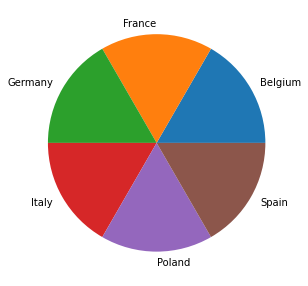

In [6]:
plot_and_display_valuecounts(train, 'country')

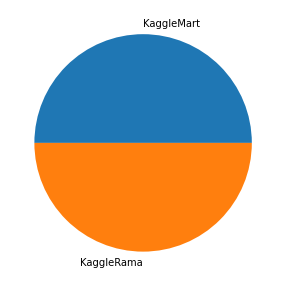

In [7]:
plot_and_display_valuecounts(train, 'store')

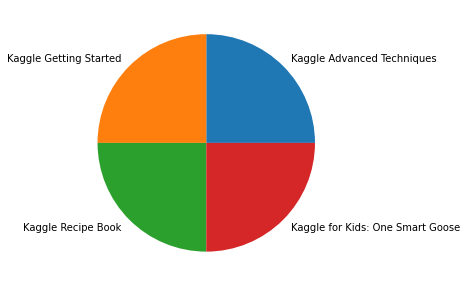

In [8]:
plot_and_display_valuecounts(train, 'product')

In [9]:
train.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

This gives us 48 univariate time series all of length 1461.
This data is equal amounts

In [10]:
# country, store, product 1주 간격으로 재정렬(num_sold 합)
weekly_df = train.groupby(['country', 'store','product', pd.Grouper(key = 'date', freq = 'W')])["num_sold"].sum().rename("num_sold").reset_index()

# country, store, product 1달 간격으로 재정렬(num_sold 합)
monthly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()
weekly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01       663
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-08      3362
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-15      2757
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-22      2863
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-29      2924

In [11]:
monthly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01     13345
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-02-01     12556
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-03-01     14137
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-04-01     14575
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-05-01     14338

In [12]:
def plot_all(df):
    f, axes = plt.subplots(2, 2, figsize = (20, 15), sharex = True, sharey = True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data = plot_df, x = 'date', y = 'num_sold', hue = 'country', style = 'store', ax = axes[n // 2, n% 2])
        axes[n // 2, n % 2].set_title("Product: "+str(prod))

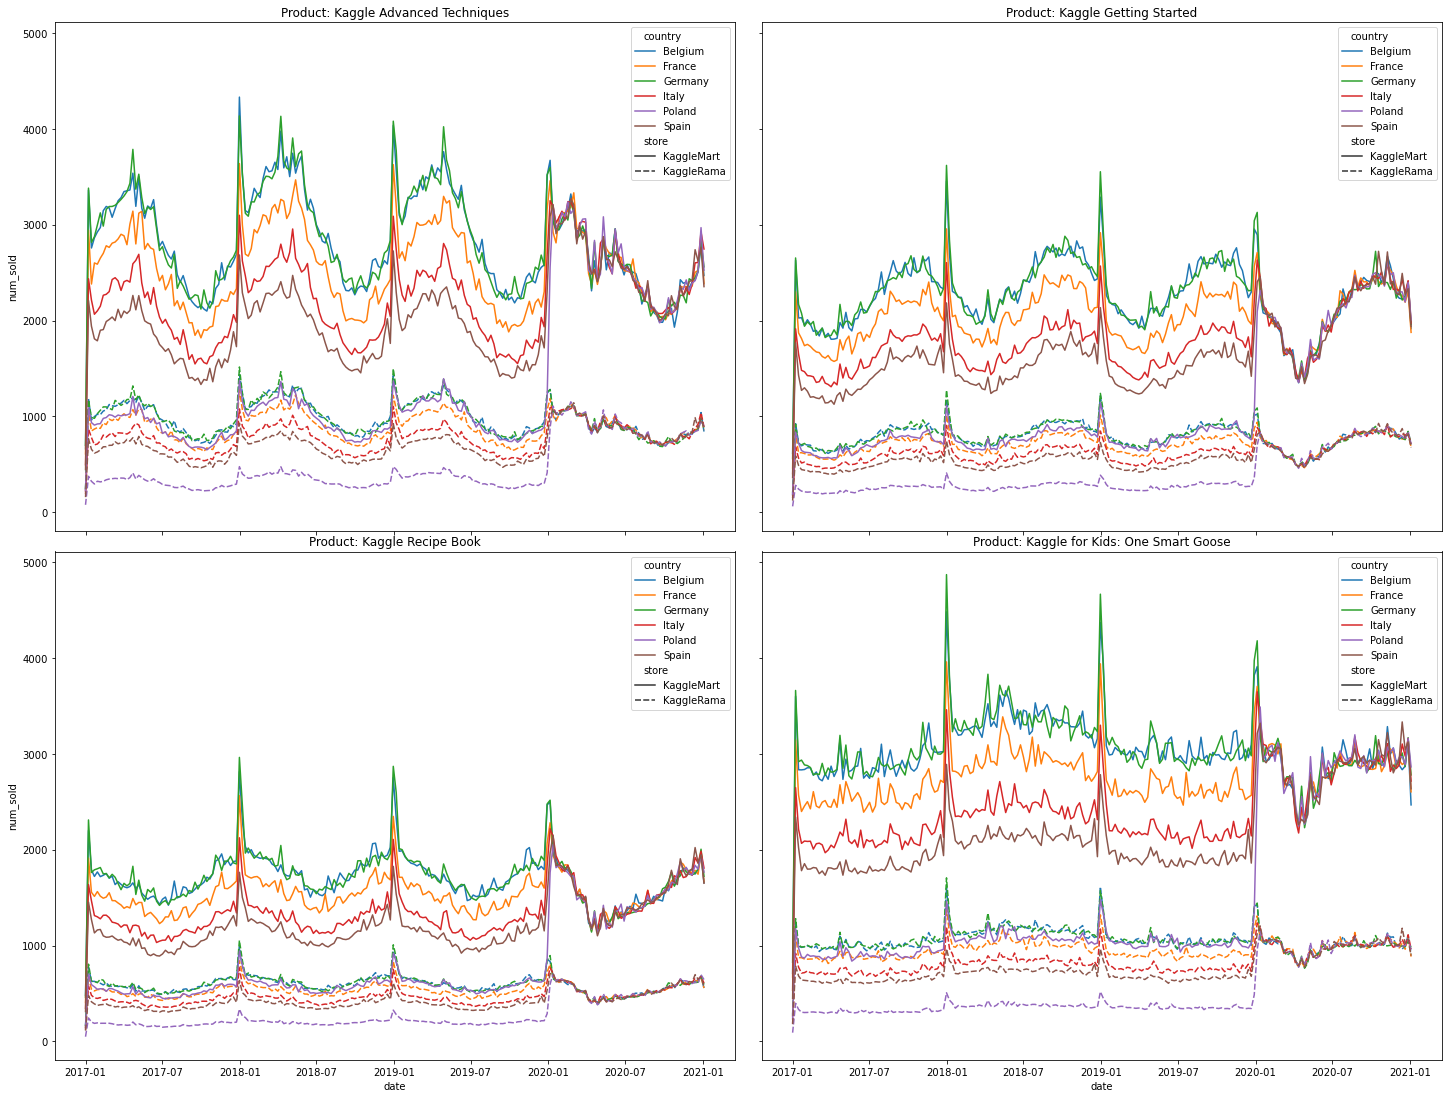

In [13]:
plot_all(weekly_df)

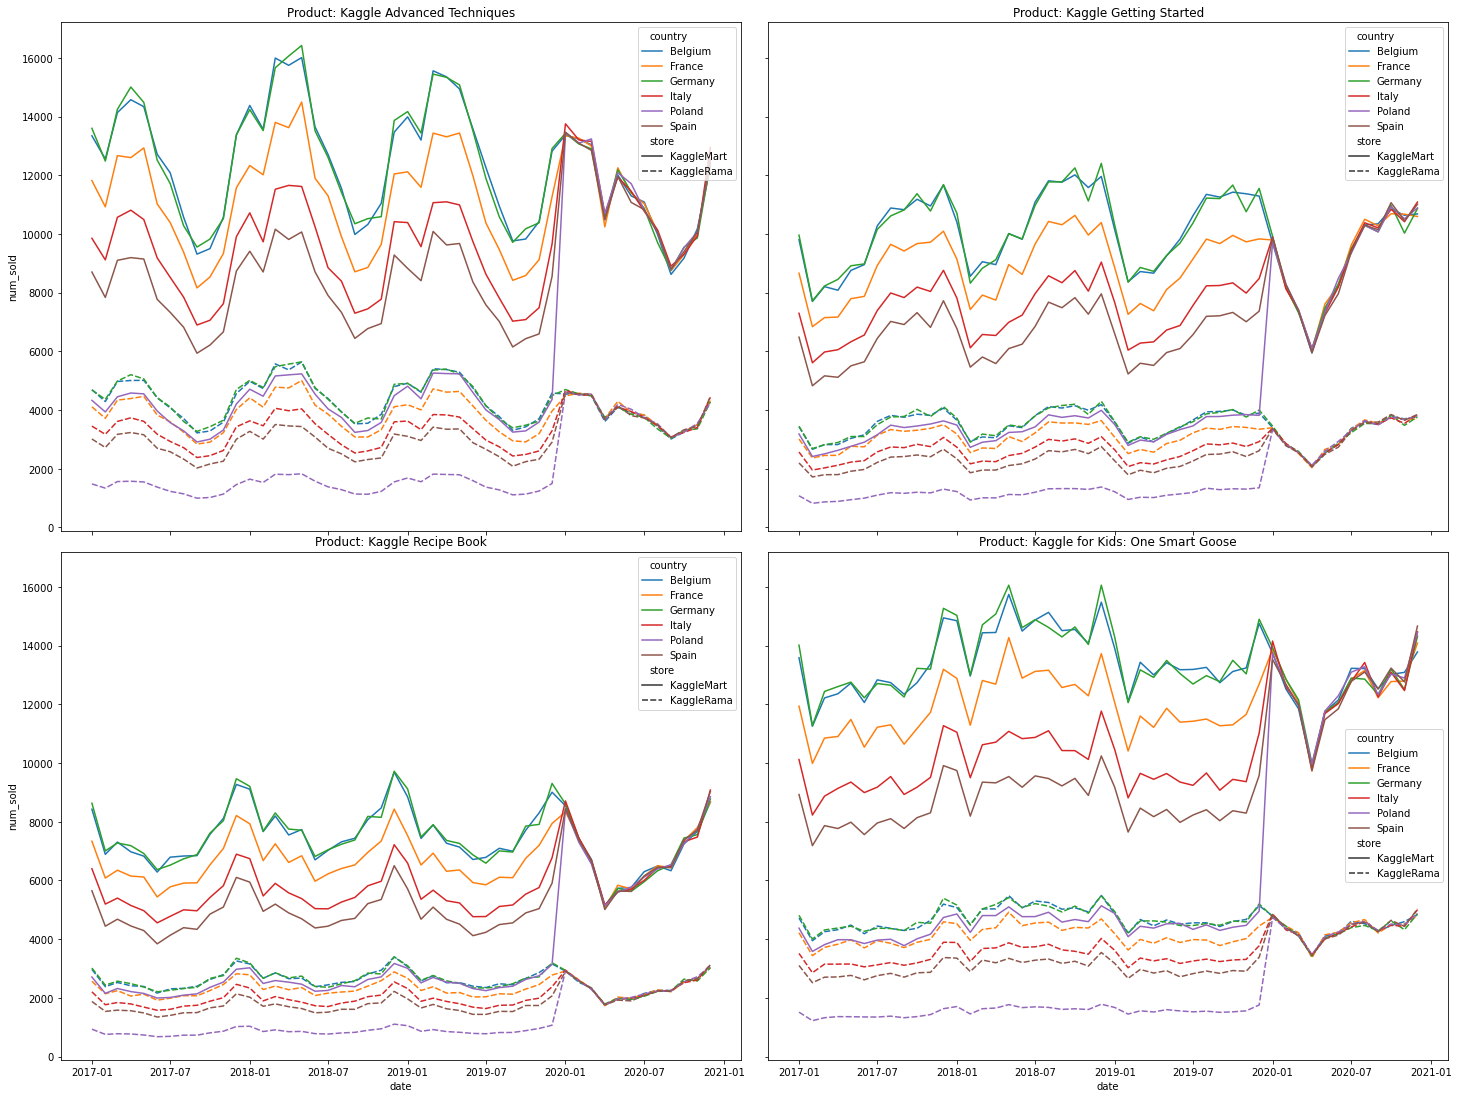

In [14]:
plot_all(monthly_df)

In [15]:
def make_radio(df, index):
    rate = str(index) + '_weights'
    radio = (df.groupby(["date",index])["num_sold"].sum() / df.groupby(["date"])["num_sold"].sum()).reset_index()
    weights = (df.groupby(index)['num_sold'].sum() / df['num_sold'].sum()).rename(rate)
    return radio, weights

In [16]:
store_ratio_over_time, store_weights = make_radio(train, "store")
store_ratio_over_time

date       store  num_sold
0    2017-01-01  KaggleMart  0.736972
1    2017-01-01  KaggleRama  0.263028
2    2017-01-02  KaggleMart  0.739679
3    2017-01-02  KaggleRama  0.260321
4    2017-01-03  KaggleMart  0.741823
...         ...         ...       ...
2917 2020-12-29  KaggleRama  0.263032
2918 2020-12-30  KaggleMart  0.741631
2919 2020-12-30  KaggleRama  0.258369
2920 2020-12-31  KaggleMart  0.738594
2921 2020-12-31  KaggleRama  0.261406

[2922 rows x 3 columns]

In [17]:
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: store_weights, dtype: float64

In [18]:
store_ratio_over_time['num_sold']

0       0.736972
1       0.263028
2       0.739679
3       0.260321
4       0.741823
          ...   
2917    0.263032
2918    0.741631
2919    0.258369
2920    0.738594
2921    0.261406
Name: num_sold, Length: 2922, dtype: float64

In [19]:
store_ratio_over_time = store_ratio_over_time.merge(store_weights, on = ['store'], how = 'left')
store_ratio_over_time

date       store  num_sold  store_weights
0    2017-01-01  KaggleMart  0.736972       0.742515
1    2017-01-01  KaggleRama  0.263028       0.257485
2    2017-01-02  KaggleMart  0.739679       0.742515
3    2017-01-02  KaggleRama  0.260321       0.257485
4    2017-01-03  KaggleMart  0.741823       0.742515
...         ...         ...       ...            ...
2917 2020-12-29  KaggleRama  0.263032       0.257485
2918 2020-12-30  KaggleMart  0.741631       0.742515
2919 2020-12-30  KaggleRama  0.258369       0.257485
2920 2020-12-31  KaggleMart  0.738594       0.742515
2921 2020-12-31  KaggleRama  0.261406       0.257485

[2922 rows x 4 columns]

In [20]:
store_ratio_over_time['minus'] = store_ratio_over_time['num_sold'] - store_ratio_over_time['store_weights']
store_ratio_over_time

date       store  num_sold  store_weights     minus
0    2017-01-01  KaggleMart  0.736972       0.742515 -0.005542
1    2017-01-01  KaggleRama  0.263028       0.257485  0.005542
2    2017-01-02  KaggleMart  0.739679       0.742515 -0.002836
3    2017-01-02  KaggleRama  0.260321       0.257485  0.002836
4    2017-01-03  KaggleMart  0.741823       0.742515 -0.000692
...         ...         ...       ...            ...       ...
2917 2020-12-29  KaggleRama  0.263032       0.257485  0.005547
2918 2020-12-30  KaggleMart  0.741631       0.742515 -0.000884
2919 2020-12-30  KaggleRama  0.258369       0.257485  0.000884
2920 2020-12-31  KaggleMart  0.738594       0.742515 -0.003921
2921 2020-12-31  KaggleRama  0.261406       0.257485  0.003921

[2922 rows x 5 columns]

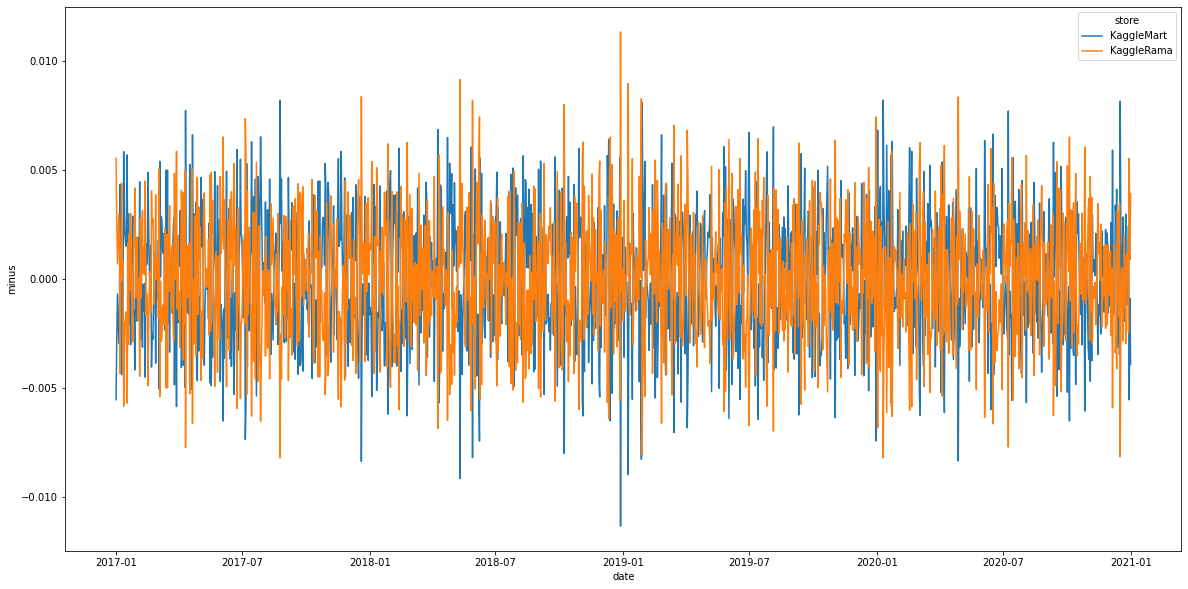

In [21]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(data = store_ratio_over_time, x = 'date', y = 'minus', hue = 'store')
ax.set_label("Proportion of sales");

In [22]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = store_weights.loc["KaggleMart"] / store_weights
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

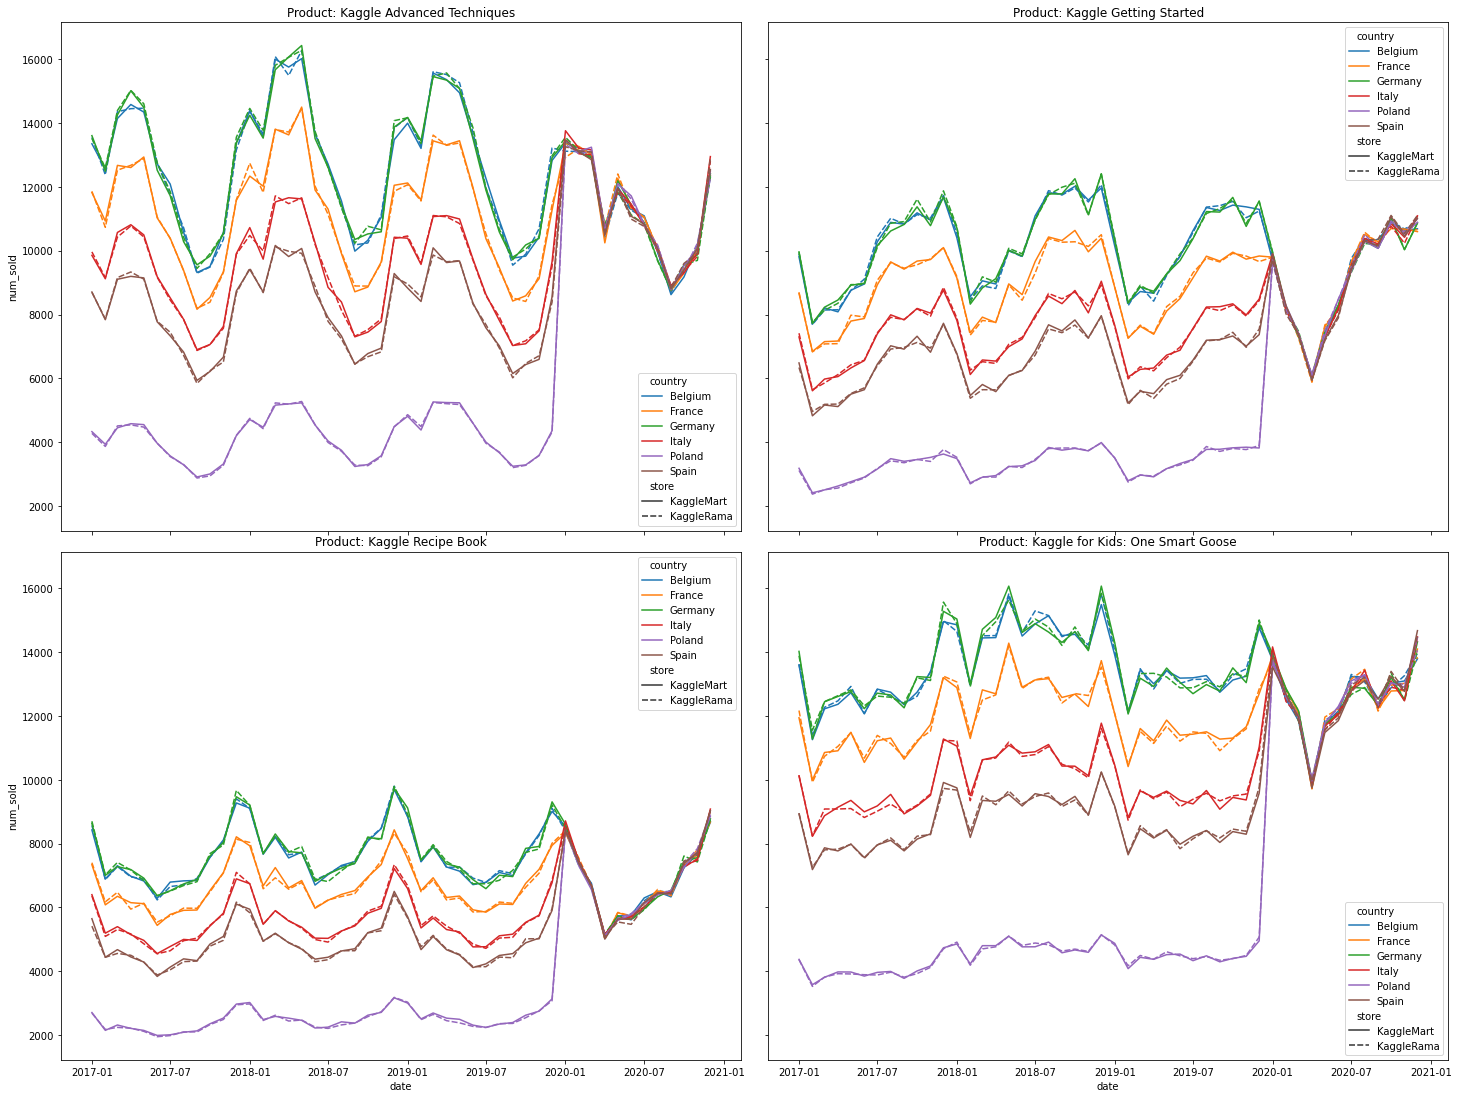

In [23]:
plot_adjusted_store(monthly_df)

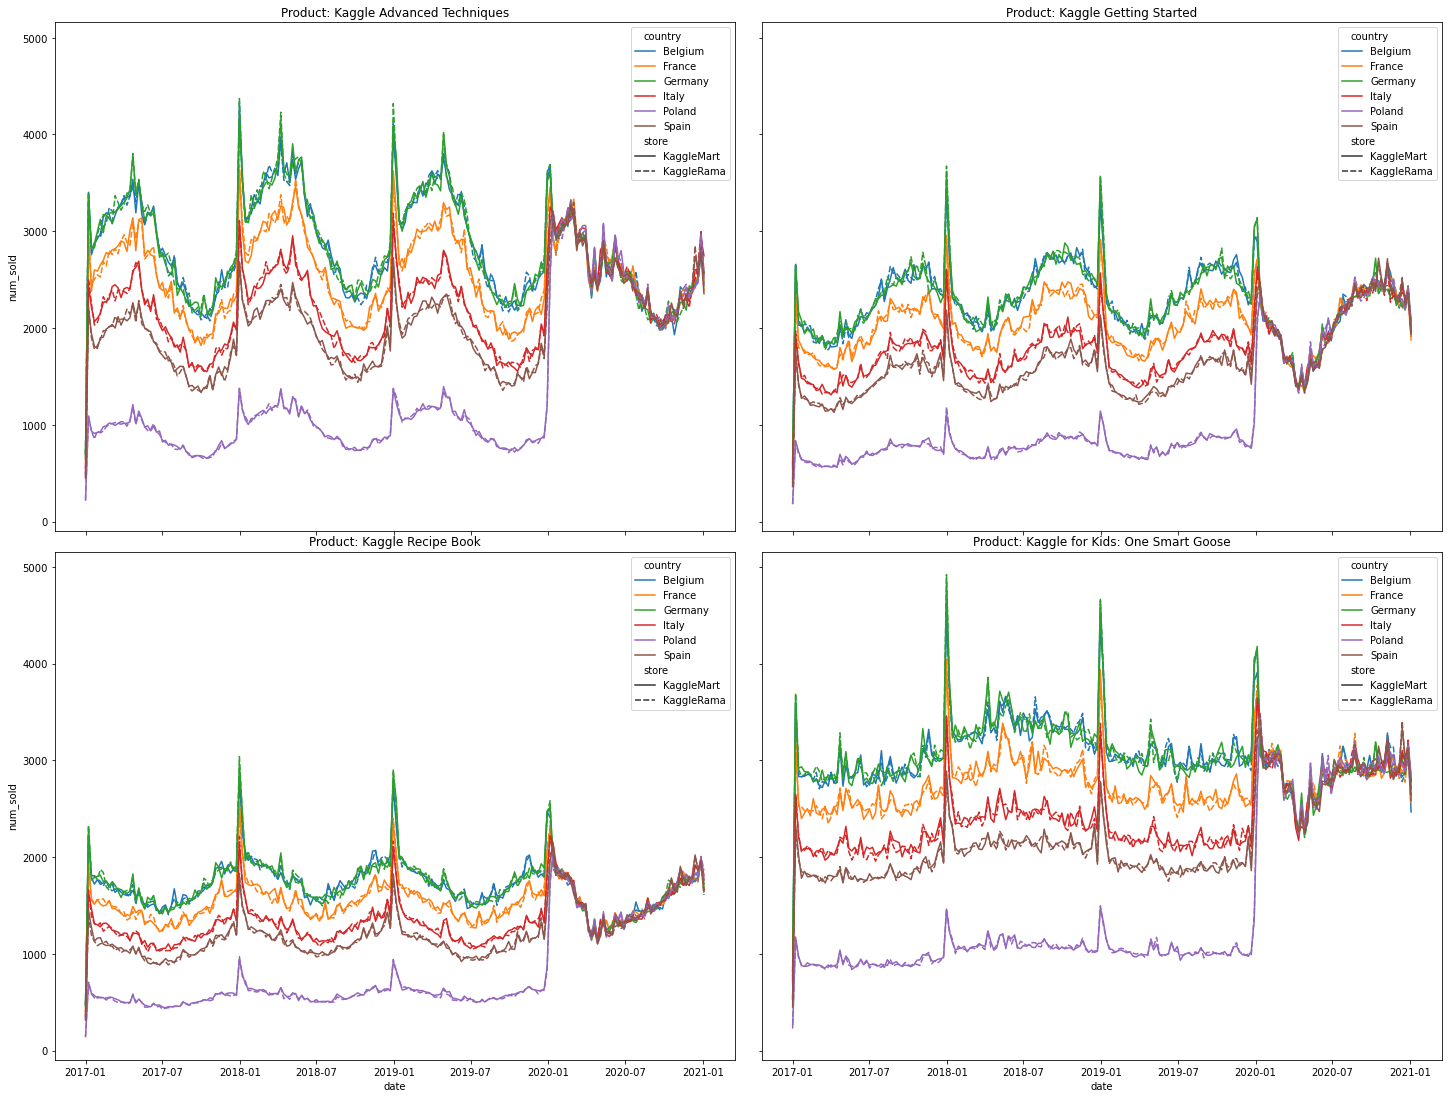

In [24]:
plot_adjusted_store(weekly_df)

In [25]:
country_ratio_over_time, country_weights = make_radio(train, "country")
country_ratio_over_time

date  country  num_sold
0    2017-01-01  Belgium  0.216258
1    2017-01-01   France  0.191441
2    2017-01-01  Germany  0.223880
3    2017-01-01    Italy  0.158351
4    2017-01-01   Poland  0.069958
...         ...      ...       ...
8761 2020-12-31   France  0.159591
8762 2020-12-31  Germany  0.172803
8763 2020-12-31    Italy  0.178028
8764 2020-12-31   Poland  0.172744
8765 2020-12-31    Spain  0.159474

[8766 rows x 3 columns]

In [26]:
country_weights

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: country_weights, dtype: float64

In [27]:
country_weights = (train.loc[train["date"] < "2020-01-01"].groupby('country')['num_sold'].sum() / train.loc[train["date"] < "2020-01-01", 'num_sold'].sum()).rename('country_weights')
country_weights

country
Belgium    0.218930
France     0.191360
Germany    0.219586
Italy      0.159383
Poland     0.071348
Spain      0.139393
Name: country_weights, dtype: float64

In [28]:
country_weights_after_2020 = country_weights.copy()
country_weights_after_2020 = (train.loc[train["date"] >= "2020-01-01"].groupby('country')['num_sold'].sum() / train.loc[train["date"] >= "2020-01-01", 'num_sold'].sum()).rename('country_weights')
country_weights_after_2020

country
Belgium    0.166528
France     0.166696
Germany    0.166257
Italy      0.167007
Poland     0.167162
Spain      0.166349
Name: country_weights, dtype: float64

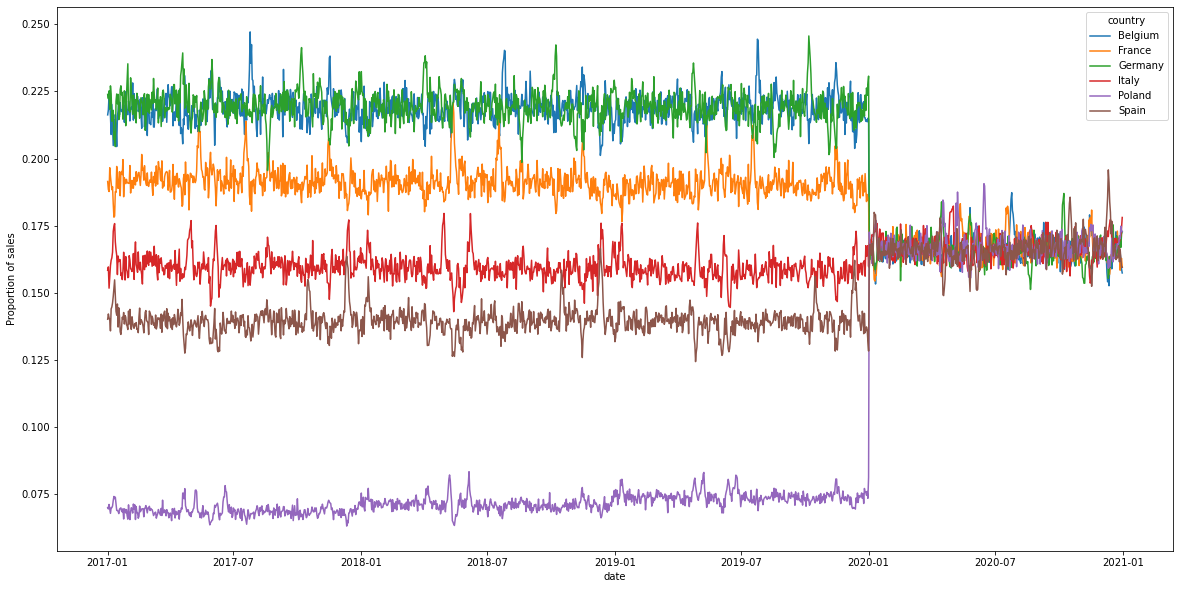

In [29]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
ax.set_ylabel("Proportion of sales");

In [30]:
def plot_adjust_country(df):
    new_df = df.copy()
    
    weights = country_weights.loc["Belgium"] / country_weights
    
    for country in weights.index:
#         2020-01-01까지만 weights를 곱하는 이유 : 2020-01-01 이후는 모든 나라에서 파는 수가 비슷하기 때문에
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  weights[country]
    #plot_country_product(new_df)
    plot_all(new_df)

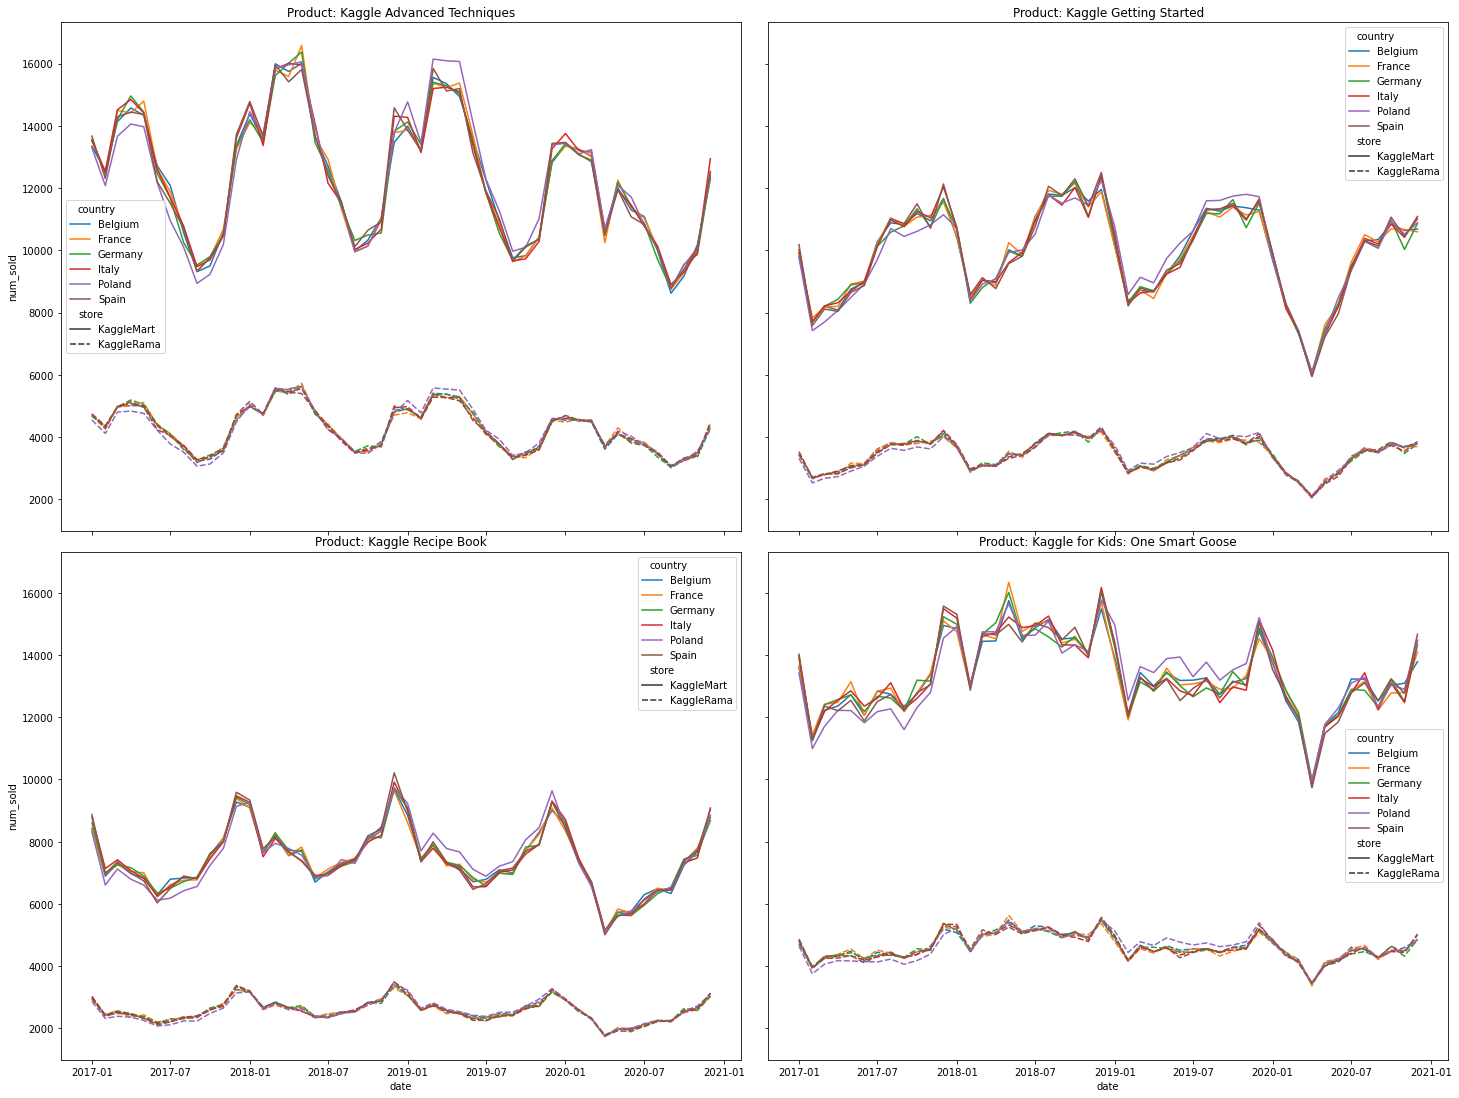

In [31]:
plot_adjust_country(monthly_df)

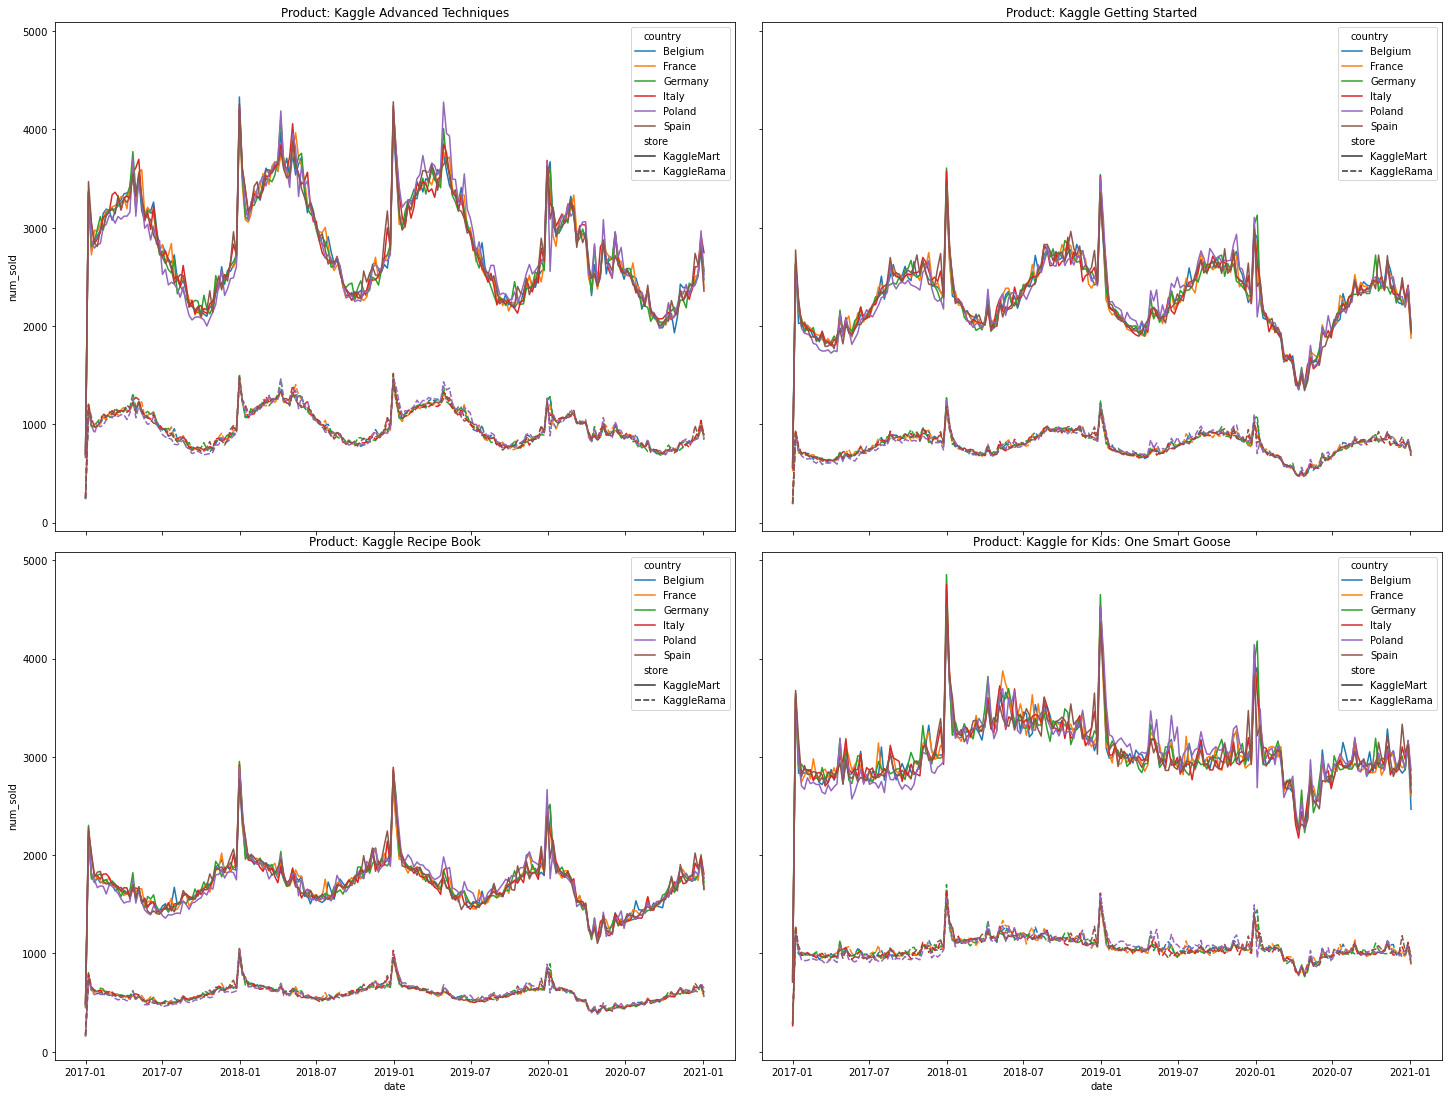

In [32]:
plot_adjust_country(weekly_df)

# Country별 rate 예측(결과 : pred_for_country_radio['pred_for_country_radio'])

In [33]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

def change_data_country(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    
    data['country'] = LabelEncoder().fit_transform(data['country'])
    data = data.drop(['date'], axis = 1)
    return data

train_country_radio = train.copy()
train_country_radio = train_country_radio.groupby(['date', 'country'])['num_sold'].sum().reset_index()
train_country_radio = train_country_radio.pivot(index="date", columns="country", values="num_sold")
train_country_radio = train_country_radio.apply(lambda x: x/x.sum(),axis=1)
train_country_radio = train_country_radio.stack().rename("country_radio").reset_index()
train_country_radio = change_data_country(train_country_radio)

test_country_sold = test.copy()
test_country_sold = test_country_sold.groupby(['date', 'country']).sum().reset_index()
test_country_sold = test_country_sold.drop(['row_id'], axis = 1)

X_train_country_radio = train_country_radio.drop(['country_radio'], axis =1)
y_train_country_radio = train_country_radio['country_radio'].copy()
test_country_radio = change_data_country(test_country_sold)

model_country_radio = XGBRegressor(random_state = 42, n_estimators = 300)
model_country_radio.fit(X_train_country_radio, y_train_country_radio)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [34]:
test_country_radio

country  year  month  day  dayofweek  quarter
0           0  2021      1    1          4        1
1           1  2021      1    1          4        1
2           2  2021      1    1          4        1
3           3  2021      1    1          4        1
4           4  2021      1    1          4        1
...       ...   ...    ...  ...        ...      ...
2185        1  2021     12   31          4        4
2186        2  2021     12   31          4        4
2187        3  2021     12   31          4        4
2188        4  2021     12   31          4        4
2189        5  2021     12   31          4        4

[2190 rows x 6 columns]

In [35]:
test_country_sold

date  country  year  month  day  dayofweek  quarter
0    2021-01-01        0  2021      1    1          4        1
1    2021-01-01        1  2021      1    1          4        1
2    2021-01-01        2  2021      1    1          4        1
3    2021-01-01        3  2021      1    1          4        1
4    2021-01-01        4  2021      1    1          4        1
...         ...      ...   ...    ...  ...        ...      ...
2185 2021-12-31        1  2021     12   31          4        4
2186 2021-12-31        2  2021     12   31          4        4
2187 2021-12-31        3  2021     12   31          4        4
2188 2021-12-31        4  2021     12   31          4        4
2189 2021-12-31        5  2021     12   31          4        4

[2190 rows x 7 columns]

In [36]:
pred = model_country_radio.predict(test_country_radio)
pred_country_radio = pd.DataFrame(pred)
pred_country_radio

0
0     0.195617
1     0.195763
2     0.214319
3     0.162483
4     0.098436
...        ...
2185  0.160841
2186  0.171253
2187  0.176634
2188  0.171402
2189  0.164887

[2190 rows x 1 columns]

In [37]:
pred_for_country_radio = []
pred_for_country_radio = pd.concat([test_country_sold, pred_country_radio], axis = 1)
pred_for_country_radio = pred_for_country_radio.rename({0 : 'pred_for_country_radio'}, axis = 1)

In [38]:
pred_for_country_radio

date  country  year  month  day  dayofweek  quarter  \
0    2021-01-01        0  2021      1    1          4        1   
1    2021-01-01        1  2021      1    1          4        1   
2    2021-01-01        2  2021      1    1          4        1   
3    2021-01-01        3  2021      1    1          4        1   
4    2021-01-01        4  2021      1    1          4        1   
...         ...      ...   ...    ...  ...        ...      ...   
2185 2021-12-31        1  2021     12   31          4        4   
2186 2021-12-31        2  2021     12   31          4        4   
2187 2021-12-31        3  2021     12   31          4        4   
2188 2021-12-31        4  2021     12   31          4        4   
2189 2021-12-31        5  2021     12   31          4        4   

      pred_for_country_radio  
0                   0.195617  
1                   0.195763  
2                   0.214319  
3                   0.162483  
4                   0.098436  
...                      ...  
2185                0.160841  
2186                0.171253  
2187                0.176634  
2188                0.171402  
2189                0.164887  

[2190 rows x 8 columns]

In [39]:
date_day = []
date_day = pred_for_country_radio.groupby(['date'])['pred_for_country_radio'].sum().rename('date_day').reset_index()
pred_for_country_radio = pred_for_country_radio.merge(date_day, on = ['date'], how = 'left')
pred_for_country_radio

date  country  year  month  day  dayofweek  quarter  \
0    2021-01-01        0  2021      1    1          4        1   
1    2021-01-01        1  2021      1    1          4        1   
2    2021-01-01        2  2021      1    1          4        1   
3    2021-01-01        3  2021      1    1          4        1   
4    2021-01-01        4  2021      1    1          4        1   
...         ...      ...   ...    ...  ...        ...      ...   
2185 2021-12-31        1  2021     12   31          4        4   
2186 2021-12-31        2  2021     12   31          4        4   
2187 2021-12-31        3  2021     12   31          4        4   
2188 2021-12-31        4  2021     12   31          4        4   
2189 2021-12-31        5  2021     12   31          4        4   

      pred_for_country_radio  date_day  
0                   0.195617  0.997056  
1                   0.195763  0.997056  
2                   0.214319  0.997056  
3                   0.162483  0.997056  
4                   0.098436  0.997056  
...                      ...       ...  
2185                0.160841  1.005202  
2186                0.171253  1.005202  
2187                0.176634  1.005202  
2188                0.171402  1.005202  
2189                0.164887  1.005202  

[2190 rows x 9 columns]

In [40]:
for i in range(0, len(pred_for_country_radio)):
    pred_for_country_radio['pred_for_country_radio'][i] = pred_for_country_radio['pred_for_country_radio'][i] / pred_for_country_radio['date_day'][i]
    
pred_for_country_radio = pred_for_country_radio.drop(['date_day'], axis = 1)
pred_for_country_radio

C:\Users\cym80\AppData\Local\Temp\ipykernel_19700\2674523048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_for_country_radio['pred_for_country_radio'][i] = pred_for_country_radio['pred_for_country_radio'][i] / pred_for_country_radio['date_day'][i]


date  country  year  month  day  dayofweek  quarter  \
0    2021-01-01        0  2021      1    1          4        1   
1    2021-01-01        1  2021      1    1          4        1   
2    2021-01-01        2  2021      1    1          4        1   
3    2021-01-01        3  2021      1    1          4        1   
4    2021-01-01        4  2021      1    1          4        1   
...         ...      ...   ...    ...  ...        ...      ...   
2185 2021-12-31        1  2021     12   31          4        4   
2186 2021-12-31        2  2021     12   31          4        4   
2187 2021-12-31        3  2021     12   31          4        4   
2188 2021-12-31        4  2021     12   31          4        4   
2189 2021-12-31        5  2021     12   31          4        4   

      pred_for_country_radio  
0                   0.196195  
1                   0.196341  
2                   0.214952  
3                   0.162963  
4                   0.098727  
...                      ...  
2185                0.160009  
2186                0.170367  
2187                0.175720  
2188                0.170515  
2189                0.164034  

[2190 rows x 8 columns]

In [41]:
pred_for_country_radio.head(30)

date  country  year  month  day  dayofweek  quarter  \
0  2021-01-01        0  2021      1    1          4        1   
1  2021-01-01        1  2021      1    1          4        1   
2  2021-01-01        2  2021      1    1          4        1   
3  2021-01-01        3  2021      1    1          4        1   
4  2021-01-01        4  2021      1    1          4        1   
5  2021-01-01        5  2021      1    1          4        1   
6  2021-01-02        0  2021      1    2          5        1   
7  2021-01-02        1  2021      1    2          5        1   
8  2021-01-02        2  2021      1    2          5        1   
9  2021-01-02        3  2021      1    2          5        1   
10 2021-01-02        4  2021      1    2          5        1   
11 2021-01-02        5  2021      1    2          5        1   
12 2021-01-03        0  2021      1    3          6        1   
13 2021-01-03        1  2021      1    3          6        1   
14 2021-01-03        2  2021      1    3          6        1   
15 2021-01-03        3  2021      1    3          6        1   
16 2021-01-03        4  2021      1    3          6        1   
17 2021-01-03        5  2021      1    3          6        1   
18 2021-01-04        0  2021      1    4          0        1   
19 2021-01-04        1  2021      1    4          0        1   
20 2021-01-04        2  2021      1    4          0        1   
21 2021-01-04        3  2021      1    4          0        1   
22 2021-01-04        4  2021      1    4          0        1   
23 2021-01-04        5  2021      1    4          0        1   
24 2021-01-05        0  2021      1    5          1        1   
25 2021-01-05        1  2021      1    5          1        1   
26 2021-01-05        2  2021      1    5          1        1   
27 2021-01-05        3  2021      1    5          1        1   
28 2021-01-05        4  2021      1    5          1        1   
29 2021-01-05        5  2021      1    5          1        1   

    pred_for_country_radio  
0                 0.196195  
1                 0.196341  
2                 0.214952  
3                 0.162963  
4                 0.098727  
5                 0.130822  
6                 0.163656  
7                 0.165309  
8                 0.169710  
9                 0.169468  
10                0.166662  
11                0.165193  
12                0.166114  
13                0.165766  
14                0.166128  
15                0.168171  
16                0.167296  
17                0.166523  
18                0.166938  
19                0.164863  
20                0.167697  
21                0.169527  
22                0.165914  
23                0.165061  
24                0.166092  
25                0.165417  
26                0.166950  
27                0.170246  
28                0.166435  
29                0.164859

In [42]:
# 확인
date_day = []
date_day = pred_for_country_radio.groupby(['date'])['pred_for_country_radio'].sum().rename('date_day').reset_index()
date_day

date  date_day
0   2021-01-01       1.0
1   2021-01-02       1.0
2   2021-01-03       1.0
3   2021-01-04       1.0
4   2021-01-05       1.0
..         ...       ...
360 2021-12-27       1.0
361 2021-12-28       1.0
362 2021-12-29       1.0
363 2021-12-30       1.0
364 2021-12-31       1.0

[365 rows x 2 columns]

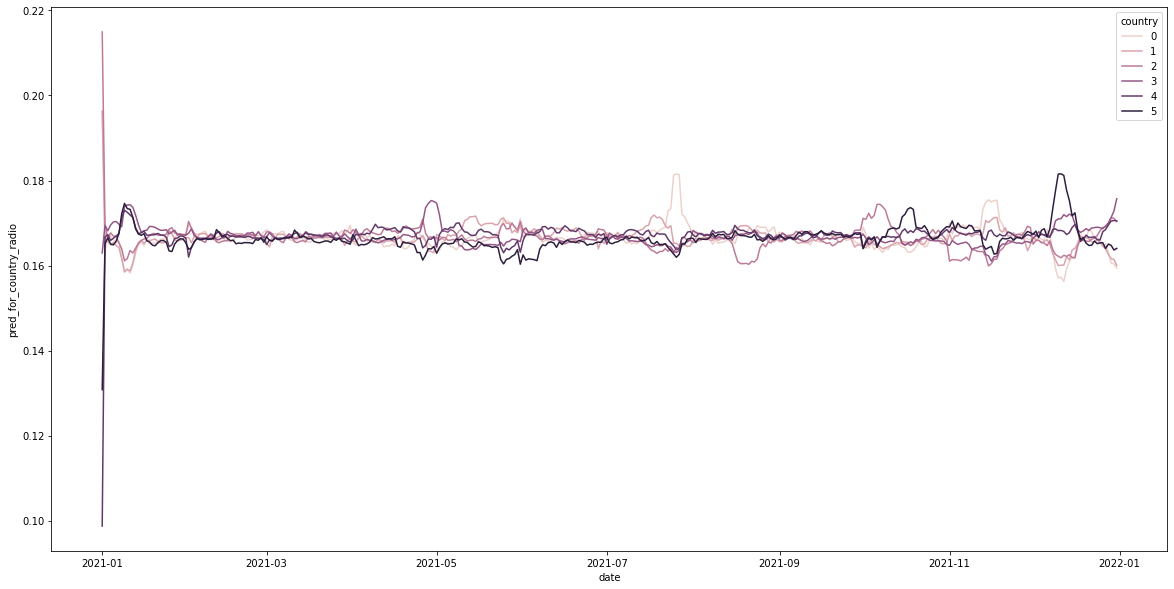

In [43]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=pred_for_country_radio, x="date", y="pred_for_country_radio", hue = 'country');

In [44]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df

date                           product  num_sold
0    2017-01-01        Kaggle Advanced Techniques      4267
1    2017-01-01            Kaggle Getting Started      3492
2    2017-01-01                Kaggle Recipe Book      2900
3    2017-01-01  Kaggle for Kids: One Smart Goose      4693
4    2017-01-02        Kaggle Advanced Techniques      3242
...         ...                               ...       ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose      5699
5840 2020-12-31        Kaggle Advanced Techniques      4968
5841 2020-12-31            Kaggle Getting Started      3780
5842 2020-12-31                Kaggle Recipe Book      3301
5843 2020-12-31  Kaggle for Kids: One Smart Goose      4982

[5844 rows x 3 columns]

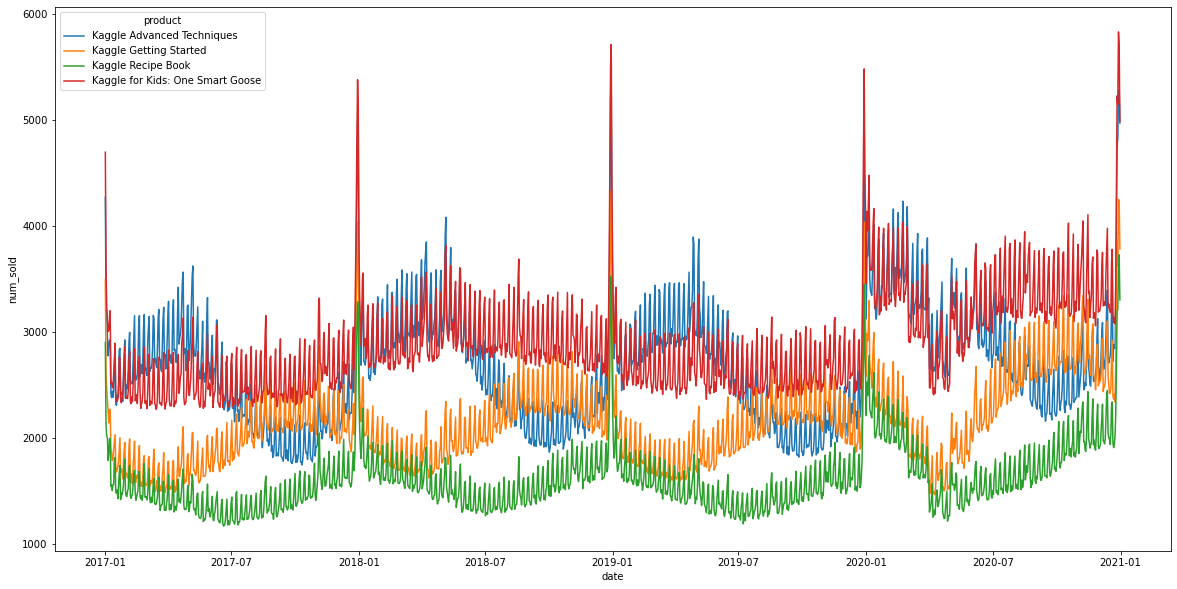

In [45]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

In [46]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_weights = (product_df.groupby("product")['num_sold'].sum() / product_df['num_sold'].sum()).rename('product_weights')
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("product_radio").reset_index()
product_ratio_df

date                           product  product_radio
0    2017-01-01        Kaggle Advanced Techniques       0.277944
1    2017-01-01            Kaggle Getting Started       0.227462
2    2017-01-01                Kaggle Recipe Book       0.188900
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693
4    2017-01-02        Kaggle Advanced Techniques       0.280014
...         ...                               ...            ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929
5840 2020-12-31        Kaggle Advanced Techniques       0.291703
5841 2020-12-31            Kaggle Getting Started       0.221948
5842 2020-12-31                Kaggle Recipe Book       0.193823
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525

[5844 rows x 3 columns]

In [47]:
product_weights

product
Kaggle Advanced Techniques          0.287246
Kaggle Getting Started              0.230220
Kaggle Recipe Book                  0.172455
Kaggle for Kids: One Smart Goose    0.310079
Name: product_weights, dtype: float64

In [48]:
product_ratio_df = product_ratio_df.merge(product_weights, on = ['product'], how = 'left')
# product_ratio_df['minus'] = product_ratio_df['product_radio'] - product_ratio_df['num_sold']
product_ratio_df

date                           product  product_radio  \
0    2017-01-01        Kaggle Advanced Techniques       0.277944   
1    2017-01-01            Kaggle Getting Started       0.227462   
2    2017-01-01                Kaggle Recipe Book       0.188900   
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693   
4    2017-01-02        Kaggle Advanced Techniques       0.280014   
...         ...                               ...            ...   
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929   
5840 2020-12-31        Kaggle Advanced Techniques       0.291703   
5841 2020-12-31            Kaggle Getting Started       0.221948   
5842 2020-12-31                Kaggle Recipe Book       0.193823   
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525   

      product_weights  
0            0.287246  
1            0.230220  
2            0.172455  
3            0.310079  
4            0.287246  
...               ...  
5839         0.310079  
5840         0.287246  
5841         0.230220  
5842         0.172455  
5843         0.310079  

[5844 rows x 4 columns]

In [49]:
product_ratio_df['minus'] = product_ratio_df['product_radio'] - product_ratio_df['product_weights']
product_ratio_df

date                           product  product_radio  \
0    2017-01-01        Kaggle Advanced Techniques       0.277944   
1    2017-01-01            Kaggle Getting Started       0.227462   
2    2017-01-01                Kaggle Recipe Book       0.188900   
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693   
4    2017-01-02        Kaggle Advanced Techniques       0.280014   
...         ...                               ...            ...   
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929   
5840 2020-12-31        Kaggle Advanced Techniques       0.291703   
5841 2020-12-31            Kaggle Getting Started       0.221948   
5842 2020-12-31                Kaggle Recipe Book       0.193823   
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525   

      product_weights     minus  
0            0.287246 -0.009301  
1            0.230220 -0.002758  
2            0.172455  0.016445  
3            0.310079 -0.004386  
4            0.287246 -0.007232  
...               ...       ...  
5839         0.310079 -0.009150  
5840         0.287246  0.004458  
5841         0.230220 -0.008272  
5842         0.172455  0.021368  
5843         0.310079 -0.017553  

[5844 rows x 5 columns]

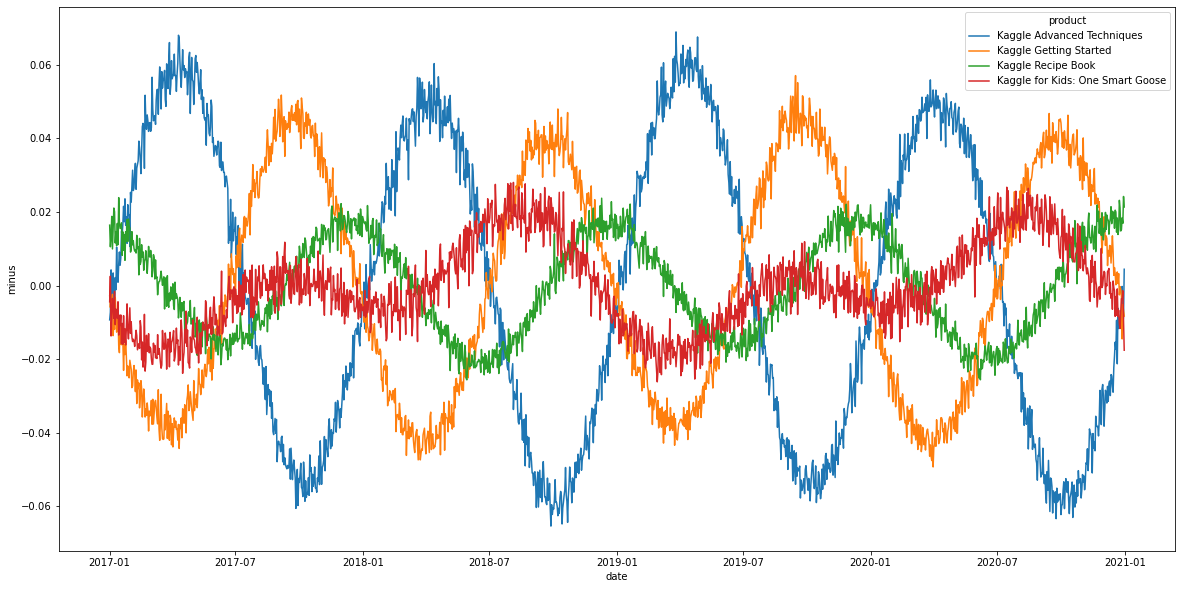

In [50]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="minus", hue="product");

# Product별 비율 예측(결과 : pred_for_product_radio['pred_for_product_radio'])

In [67]:
train_product_radio = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_weights = (train_product_radio.groupby("product")['num_sold'].sum() / train_product_radio['num_sold'].sum()).rename('product_weights')
train_product_radio = train_product_radio.pivot(index="date", columns="product", values="num_sold")
# product / 하루동안 팔린 책
train_product_radio = train_product_radio.apply(lambda x: x/x.sum(),axis=1)
train_product_radio = train_product_radio.stack().rename("product_radio").reset_index()
train_product_radio_date = train_product_radio

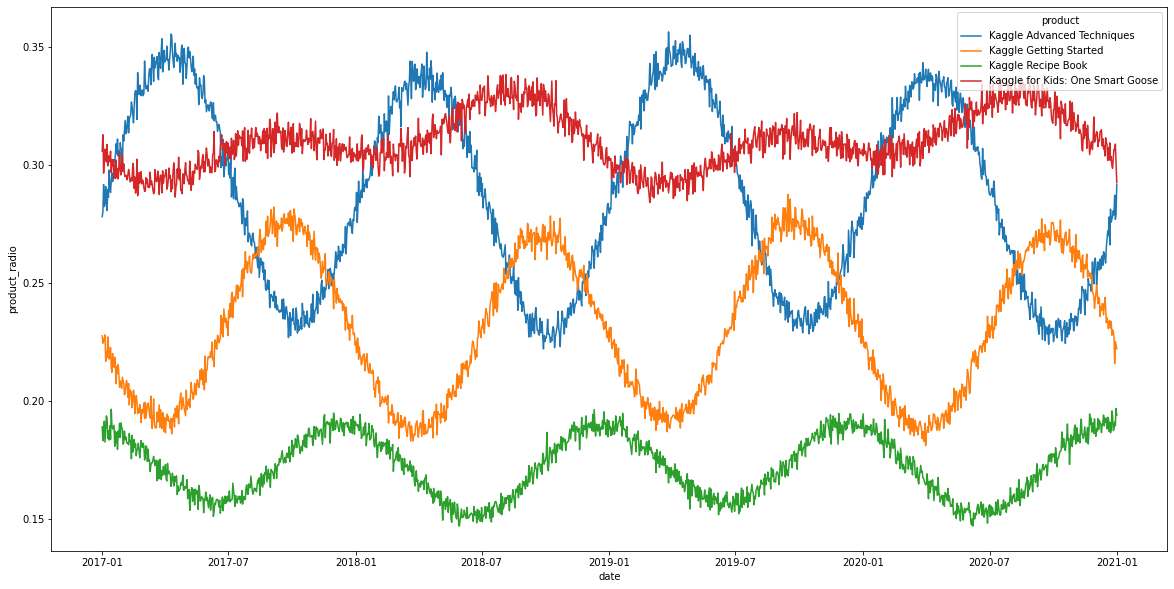

In [68]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_product_radio, x="date", y="product_radio", hue="product");

In [69]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

def change_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    
    data['product'] = LabelEncoder().fit_transform(data['product'])
    data = data.drop(['date'], axis = 1)
    return data

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
train_product_radio = change_data(train_product_radio_date.copy())
X_train_product_radio = train_product_radio.drop(['product_radio'], axis = 1)
y_train_product_radio = train_product_radio['product_radio'].copy()
test_product_sold = test.groupby(['date', 'product']).sum().reset_index()
test_product_sold = test_product_sold.drop(['row_id'], axis = 1)

test_product_radio = change_data(test_product_sold)

model_1 = RandomForestRegressor(random_state = 42)
model_1.fit(X_train_product_radio, y_train_product_radio)

model_2 = XGBRegressor(random_state = 42)
model_2.fit(X_train_product_radio, y_train_product_radio)

model_product_radio = VotingRegressor(estimators = [('rf', model_1), ('xgb', model_2)])
model_product_radio.fit(X_train_product_radio, y_train_product_radio)

VotingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, max_cat_to_onehot=4,
                                          max_delta_step=0, max_depth=6,
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, ...))])

In [70]:
train_product_radio = pd.concat([train_product_radio_date['date'], train_product_radio], axis = 1)
train_product_radio

date  product  product_radio  year  month  day  dayofweek  quarter
0    2017-01-01        0       0.277944  2017      1    1          6        1
1    2017-01-01        1       0.227462  2017      1    1          6        1
2    2017-01-01        2       0.188900  2017      1    1          6        1
3    2017-01-01        3       0.305693  2017      1    1          6        1
4    2017-01-02        0       0.280014  2017      1    2          0        1
...         ...      ...            ...   ...    ...  ...        ...      ...
5839 2020-12-30        3       0.300929  2020     12   30          2        4
5840 2020-12-31        0       0.291703  2020     12   31          3        4
5841 2020-12-31        1       0.221948  2020     12   31          3        4
5842 2020-12-31        2       0.193823  2020     12   31          3        4
5843 2020-12-31        3       0.292525  2020     12   31          3        4

[5844 rows x 8 columns]

In [54]:
pred = model_product_radio.predict(test_product_radio)
pred

array([0.28037907, 0.22560865, 0.19234088, ..., 0.22266374, 0.19358153,
       0.29872446])

In [55]:
pred_for_product_radio = pd.DataFrame(pred.copy())
pred_for_product_radio = pred_for_product_radio.rename({0 : 'pred_for_product_radio'}, axis = 1)
pred_for_product_radio

pred_for_product_radio
0                   0.280379
1                   0.225609
2                   0.192341
3                   0.304147
4                   0.281566
...                      ...
1455                0.300858
1456                0.285943
1457                0.222664
1458                0.193582
1459                0.298724

[1460 rows x 1 columns]

In [56]:
pred_for_product_radio = pd.concat([test_product_sold, pred_for_product_radio], axis = 1)
pred_for_product_radio

date  product  year  month  day  dayofweek  quarter  \
0    2021-01-01        0  2021      1    1          4        1   
1    2021-01-01        1  2021      1    1          4        1   
2    2021-01-01        2  2021      1    1          4        1   
3    2021-01-01        3  2021      1    1          4        1   
4    2021-01-02        0  2021      1    2          5        1   
...         ...      ...   ...    ...  ...        ...      ...   
1455 2021-12-30        3  2021     12   30          3        4   
1456 2021-12-31        0  2021     12   31          4        4   
1457 2021-12-31        1  2021     12   31          4        4   
1458 2021-12-31        2  2021     12   31          4        4   
1459 2021-12-31        3  2021     12   31          4        4   

      pred_for_product_radio  
0                   0.280379  
1                   0.225609  
2                   0.192341  
3                   0.304147  
4                   0.281566  
...                      ...  
1455                0.300858  
1456                0.285943  
1457                0.222664  
1458                0.193582  
1459                0.298724  

[1460 rows x 8 columns]

In [57]:
date_day = []
date_day = pred_for_product_radio.groupby(['date'])['pred_for_product_radio'].sum().rename('date_day').reset_index()
pred_for_product_radio = pred_for_product_radio.merge(date_day, on = ['date'], how = 'left')
pred_for_product_radio

date  product  year  month  day  dayofweek  quarter  \
0    2021-01-01        0  2021      1    1          4        1   
1    2021-01-01        1  2021      1    1          4        1   
2    2021-01-01        2  2021      1    1          4        1   
3    2021-01-01        3  2021      1    1          4        1   
4    2021-01-02        0  2021      1    2          5        1   
...         ...      ...   ...    ...  ...        ...      ...   
1455 2021-12-30        3  2021     12   30          3        4   
1456 2021-12-31        0  2021     12   31          4        4   
1457 2021-12-31        1  2021     12   31          4        4   
1458 2021-12-31        2  2021     12   31          4        4   
1459 2021-12-31        3  2021     12   31          4        4   

      pred_for_product_radio  date_day  
0                   0.280379  1.002476  
1                   0.225609  1.002476  
2                   0.192341  1.002476  
3                   0.304147  1.002476  
4                   0.281566  0.998881  
...                      ...       ...  
1455                0.300858  0.999434  
1456                0.285943  1.000912  
1457                0.222664  1.000912  
1458                0.193582  1.000912  
1459                0.298724  1.000912  

[1460 rows x 9 columns]

한 날이 다 더했을때 1이 되도록

In [58]:
for i in range(0, len(pred_for_product_radio)):
    pred_for_product_radio['pred_for_product_radio'][i] = pred_for_product_radio['pred_for_product_radio'][i] / pred_for_product_radio['date_day'][i]
    
pred_for_product_radio = pred_for_product_radio.drop(['date_day'], axis = 1)
pred_for_product_radio

C:\Users\cym80\AppData\Local\Temp\ipykernel_19700\452393835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_for_product_radio['pred_for_product_radio'][i] = pred_for_product_radio['pred_for_product_radio'][i] / pred_for_product_radio['date_day'][i]


date  product  year  month  day  dayofweek  quarter  \
0    2021-01-01        0  2021      1    1          4        1   
1    2021-01-01        1  2021      1    1          4        1   
2    2021-01-01        2  2021      1    1          4        1   
3    2021-01-01        3  2021      1    1          4        1   
4    2021-01-02        0  2021      1    2          5        1   
...         ...      ...   ...    ...  ...        ...      ...   
1455 2021-12-30        3  2021     12   30          3        4   
1456 2021-12-31        0  2021     12   31          4        4   
1457 2021-12-31        1  2021     12   31          4        4   
1458 2021-12-31        2  2021     12   31          4        4   
1459 2021-12-31        3  2021     12   31          4        4   

      pred_for_product_radio  
0                   0.279687  
1                   0.225051  
2                   0.191866  
3                   0.303396  
4                   0.281882  
...                      ...  
1455                0.301029  
1456                0.285682  
1457                0.222461  
1458                0.193405  
1459                0.298452  

[1460 rows x 8 columns]

In [59]:
# 확인
date_day = []
date_day = pred_for_product_radio.groupby(['date'])['pred_for_product_radio'].sum().rename('date_day').reset_index()
date_day

date  date_day
0   2021-01-01       1.0
1   2021-01-02       1.0
2   2021-01-03       1.0
3   2021-01-04       1.0
4   2021-01-05       1.0
..         ...       ...
360 2021-12-27       1.0
361 2021-12-28       1.0
362 2021-12-29       1.0
363 2021-12-30       1.0
364 2021-12-31       1.0

[365 rows x 2 columns]

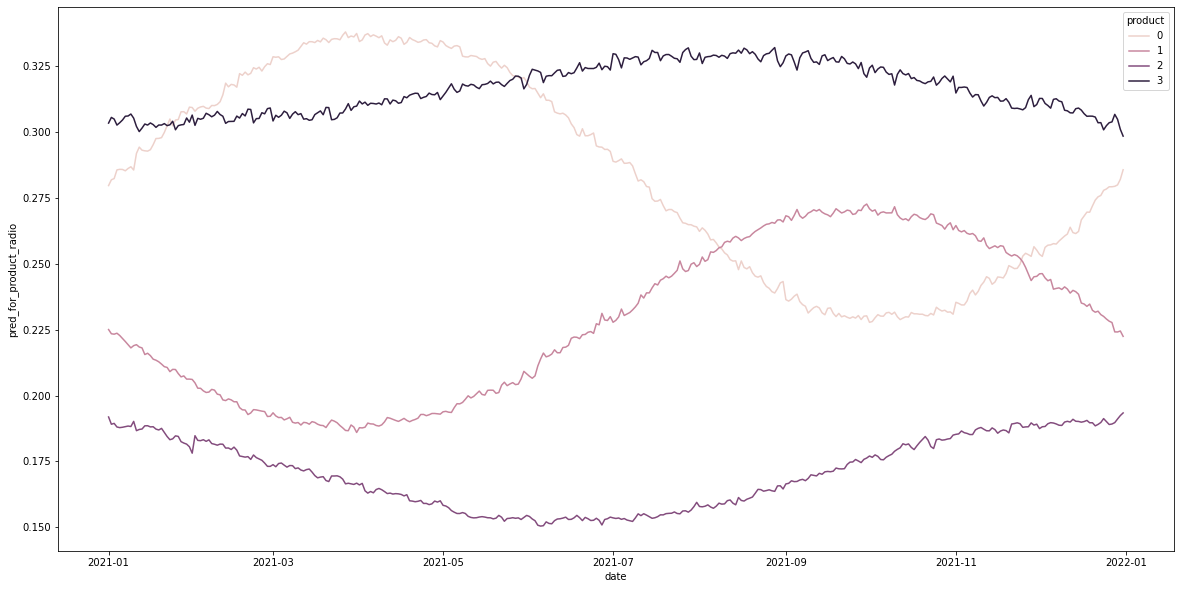

In [60]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = pred_for_product_radio, x="date", y="pred_for_product_radio", hue="product");

# 하루 num_sold를 예측 후 각각의 가중치를 곱함

In [61]:
weights = pd.DataFrame(store_weights.copy())
weights

store_weights
store                    
KaggleMart       0.742515
KaggleRama       0.257485

In [135]:
test_data = test.copy()
test_data['country'] = LabelEncoder().fit_transform(test_data['country'])
test_data['product'] = LabelEncoder().fit_transform(test_data['product'])
test_data

row_id       date  country       store  product
0       70128 2021-01-01        0  KaggleMart        0
1       70129 2021-01-01        0  KaggleMart        1
2       70130 2021-01-01        0  KaggleMart        2
3       70131 2021-01-01        0  KaggleMart        3
4       70132 2021-01-01        0  KaggleRama        0
...       ...        ...      ...         ...      ...
17515   87643 2021-12-31        5  KaggleMart        3
17516   87644 2021-12-31        5  KaggleRama        0
17517   87645 2021-12-31        5  KaggleRama        1
17518   87646 2021-12-31        5  KaggleRama        2
17519   87647 2021-12-31        5  KaggleRama        3

[17520 rows x 5 columns]

In [136]:
test_data = test_data.merge(pred_for_product_radio, on = ['date', 'product'], how = 'left')
test_data = test_data.merge(pred_for_country_radio, on = ['date', 'country', 'year', 'month', 'day', 'dayofweek', 'quarter'], how = 'left')
test_data = test_data.merge(store_weights, on = ['store'], how = 'left')
test_data['store'] = LabelEncoder().fit_transform(test_data['store'])
test_data = test_data.drop(['date'], axis = 1)
test_data = test_data.rename({'pred_for_product_radio' : 'product_radio', 'pred_for_country_radio' : 'country_radio'}, axis = 1)

test_data

row_id  country  store  product  year  month  day  dayofweek  quarter  \
0       70128        0      0        0  2021      1    1          4        1   
1       70129        0      0        1  2021      1    1          4        1   
2       70130        0      0        2  2021      1    1          4        1   
3       70131        0      0        3  2021      1    1          4        1   
4       70132        0      1        0  2021      1    1          4        1   
...       ...      ...    ...      ...   ...    ...  ...        ...      ...   
17515   87643        5      0        3  2021     12   31          4        4   
17516   87644        5      1        0  2021     12   31          4        4   
17517   87645        5      1        1  2021     12   31          4        4   
17518   87646        5      1        2  2021     12   31          4        4   
17519   87647        5      1        3  2021     12   31          4        4   

       product_radio  country_radio  store_weights  
0           0.279687       0.196195       0.742515  
1           0.225051       0.196195       0.742515  
2           0.191866       0.196195       0.742515  
3           0.303396       0.196195       0.742515  
4           0.279687       0.196195       0.257485  
...              ...            ...            ...  
17515       0.298452       0.164034       0.742515  
17516       0.285682       0.164034       0.257485  
17517       0.222461       0.164034       0.257485  
17518       0.193405       0.164034       0.257485  
17519       0.298452       0.164034       0.257485  

[17520 rows x 12 columns]

In [137]:
train_data = train.copy()
train_data['country'] = LabelEncoder().fit_transform(train_data['country'])
train_data['product'] = LabelEncoder().fit_transform(train_data['product'])
train_data = train_data.drop(['num_sold'], axis = 1)
train_data

row_id       date  country       store  product
0           0 2017-01-01        0  KaggleMart        0
1           1 2017-01-01        0  KaggleMart        1
2           2 2017-01-01        0  KaggleMart        2
3           3 2017-01-01        0  KaggleMart        3
4           4 2017-01-01        0  KaggleRama        0
...       ...        ...      ...         ...      ...
70123   70123 2020-12-31        5  KaggleMart        3
70124   70124 2020-12-31        5  KaggleRama        0
70125   70125 2020-12-31        5  KaggleRama        1
70126   70126 2020-12-31        5  KaggleRama        2
70127   70127 2020-12-31        5  KaggleRama        3

[70128 rows x 5 columns]

In [138]:
train_product_radio

date  product  product_radio  year  month  day  dayofweek  quarter
0    2017-01-01        0       0.277944  2017      1    1          6        1
1    2017-01-01        1       0.227462  2017      1    1          6        1
2    2017-01-01        2       0.188900  2017      1    1          6        1
3    2017-01-01        3       0.305693  2017      1    1          6        1
4    2017-01-02        0       0.280014  2017      1    2          0        1
...         ...      ...            ...   ...    ...  ...        ...      ...
5839 2020-12-30        3       0.300929  2020     12   30          2        4
5840 2020-12-31        0       0.291703  2020     12   31          3        4
5841 2020-12-31        1       0.221948  2020     12   31          3        4
5842 2020-12-31        2       0.193823  2020     12   31          3        4
5843 2020-12-31        3       0.292525  2020     12   31          3        4

[5844 rows x 8 columns]

In [139]:
train_country_radio

country  country_radio  year  month  day  dayofweek  quarter
0           0       0.216258  2017      1    1          6        1
1           1       0.191441  2017      1    1          6        1
2           2       0.223880  2017      1    1          6        1
3           3       0.158351  2017      1    1          6        1
4           4       0.069958  2017      1    1          6        1
...       ...            ...   ...    ...  ...        ...      ...
8761        1       0.159591  2020     12   31          3        4
8762        2       0.172803  2020     12   31          3        4
8763        3       0.178028  2020     12   31          3        4
8764        4       0.172744  2020     12   31          3        4
8765        5       0.159474  2020     12   31          3        4

[8766 rows x 7 columns]

In [140]:
train_sold_total = train.groupby(['date'])['num_sold'].sum().reset_index()
train_sold_total

date  num_sold
0    2017-01-01     15352
1    2017-01-02     11578
2    2017-01-03     10884
3    2017-01-04     10445
4    2017-01-05      9795
...         ...       ...
1456 2020-12-27     17042
1457 2020-12-28     16789
1458 2020-12-29     18876
1459 2020-12-30     18938
1460 2020-12-31     17031

[1461 rows x 2 columns]

In [141]:
train_data = train_data.merge(train_product_radio, on = ['date', 'product'], how = 'left')
train_data = train_data.merge(train_country_radio, on = ['country', 'year', 'month', 'day', 'dayofweek', 'quarter'], how = 'left')
train_data = train_data.merge(store_weights, on = ['store'], how = 'left')
train_data = train_data.merge(train_sold_total, on = ['date'], how = 'left')
train_data['store'] = LabelEncoder().fit_transform(train_data['store'])
train_data = train_data.drop(['date'], axis = 1)

train_data

row_id  country  store  product  product_radio  year  month  day  \
0           0        0      0        0       0.277944  2017      1    1   
1           1        0      0        1       0.227462  2017      1    1   
2           2        0      0        2       0.188900  2017      1    1   
3           3        0      0        3       0.305693  2017      1    1   
4           4        0      1        0       0.277944  2017      1    1   
...       ...      ...    ...      ...            ...   ...    ...  ...   
70123   70123        5      0        3       0.292525  2020     12   31   
70124   70124        5      1        0       0.291703  2020     12   31   
70125   70125        5      1        1       0.221948  2020     12   31   
70126   70126        5      1        2       0.193823  2020     12   31   
70127   70127        5      1        3       0.292525  2020     12   31   

       dayofweek  quarter  country_radio  store_weights  num_sold  
0              6        1       0.216258       0.742515     15352  
1              6        1       0.216258       0.742515     15352  
2              6        1       0.216258       0.742515     15352  
3              6        1       0.216258       0.742515     15352  
4              6        1       0.216258       0.257485     15352  
...          ...      ...            ...            ...       ...  
70123          3        4       0.159474       0.742515     17031  
70124          3        4       0.159474       0.257485     17031  
70125          3        4       0.159474       0.257485     17031  
70126          3        4       0.159474       0.257485     17031  
70127          3        4       0.159474       0.257485     17031  

[70128 rows x 13 columns]

In [142]:
X_train = train_data.drop(['num_sold'], axis = 1)
y_train = train_data['num_sold'].copy()

model = XGBRegressor(random_state = 42)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
XGB_param_grid = {
    'n_estimators' : [130, 140, 150, 160, 170],
    'min_child_weight' : [1, 2, 4, 5],
    'gamma' : [0, 0.1, 0.01, 0.001, 0.0001],
    'subsample' : [0.4, 0.5, 0.6],
    'colsample_bytree' : [0.55, 0.6, 0.65, 0.7],
    'max_depth' : [2, 3, 4, 5]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_xgb = GridSearchCV(model, param_grid = XGB_param_grid, cv = 5, verbose = 3)
grid_xgb.fit(X_train, y_train)

In [ ]:
print(grid_xgb.best_params_)

In [ ]:
model = XGBRegressor(random_state = 42, n_estimators = grid_xgb.best_params_['n_estimators'],
                                   gamma = grid_xgb.best_params_['gamma'],
                                   max_depth = grid_xgb.best_params_['max_depth'],
                                   min_child_weight = grid_xgb.best_params_['min_child_weight'],
                                   subsample = grid_xgb.best_params_['subsample'],
                                   colsample_bytree = grid_xgb.best_params_['colsample_bytree'])
model.fit(X_train, y_train)

In [143]:
pred = model.predict(test_data)
pred

array([16773.314, 16802.668, 16814.338, ..., 17081.627, 17081.627,
       17081.627], dtype=float32)

In [144]:
pred_for_per_day = pred.copy()
pred_for_per_day = pd.DataFrame(pred_for_per_day)
pred_for_per_day = pred_for_per_day.rename({0 : 'num_sold'}, axis = 1)
pred_for_per_day

num_sold
0      16773.314453
1      16802.667969
2      16814.337891
3      16811.966797
4      16773.314453
...             ...
17515  17081.626953
17516  17081.626953
17517  17081.626953
17518  17081.626953
17519  17081.626953

[17520 rows x 1 columns]

In [145]:
test_data = pd.concat([test_data, pred_for_per_day], axis = 1)
test_data

row_id  country  store  product  year  month  day  dayofweek  quarter  \
0       70128        0      0        0  2021      1    1          4        1   
1       70129        0      0        1  2021      1    1          4        1   
2       70130        0      0        2  2021      1    1          4        1   
3       70131        0      0        3  2021      1    1          4        1   
4       70132        0      1        0  2021      1    1          4        1   
...       ...      ...    ...      ...   ...    ...  ...        ...      ...   
17515   87643        5      0        3  2021     12   31          4        4   
17516   87644        5      1        0  2021     12   31          4        4   
17517   87645        5      1        1  2021     12   31          4        4   
17518   87646        5      1        2  2021     12   31          4        4   
17519   87647        5      1        3  2021     12   31          4        4   

       product_radio  country_radio  store_weights      num_sold  
0           0.279687       0.196195       0.742515  16773.314453  
1           0.225051       0.196195       0.742515  16802.667969  
2           0.191866       0.196195       0.742515  16814.337891  
3           0.303396       0.196195       0.742515  16811.966797  
4           0.279687       0.196195       0.257485  16773.314453  
...              ...            ...            ...           ...  
17515       0.298452       0.164034       0.742515  17081.626953  
17516       0.285682       0.164034       0.257485  17081.626953  
17517       0.222461       0.164034       0.257485  17081.626953  
17518       0.193405       0.164034       0.257485  17081.626953  
17519       0.298452       0.164034       0.257485  17081.626953  

[17520 rows x 13 columns]

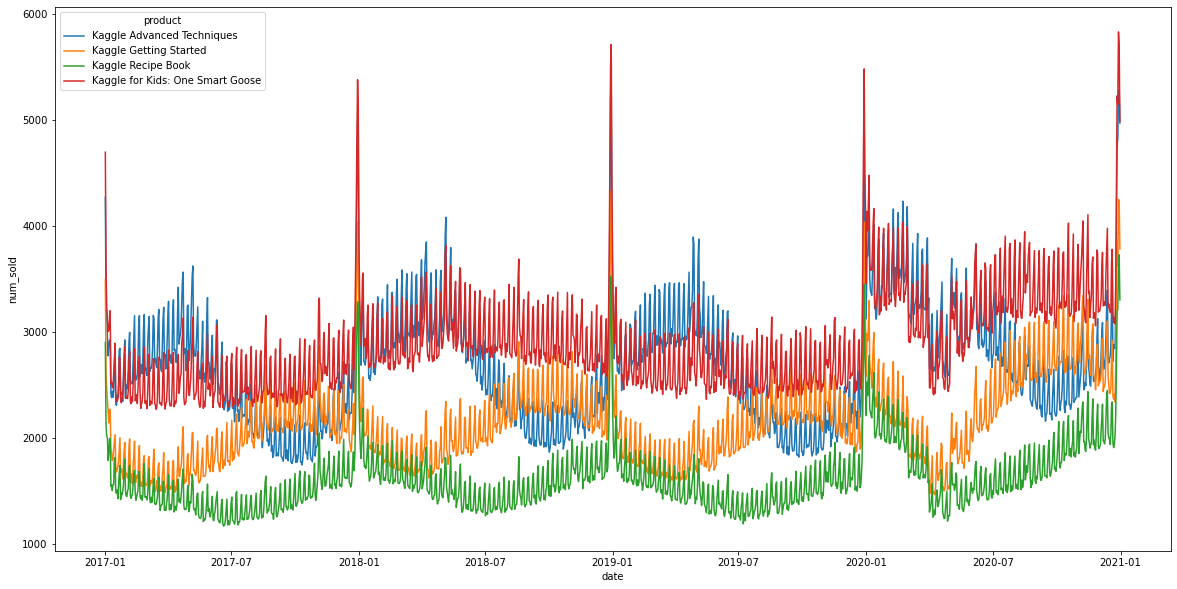

In [146]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

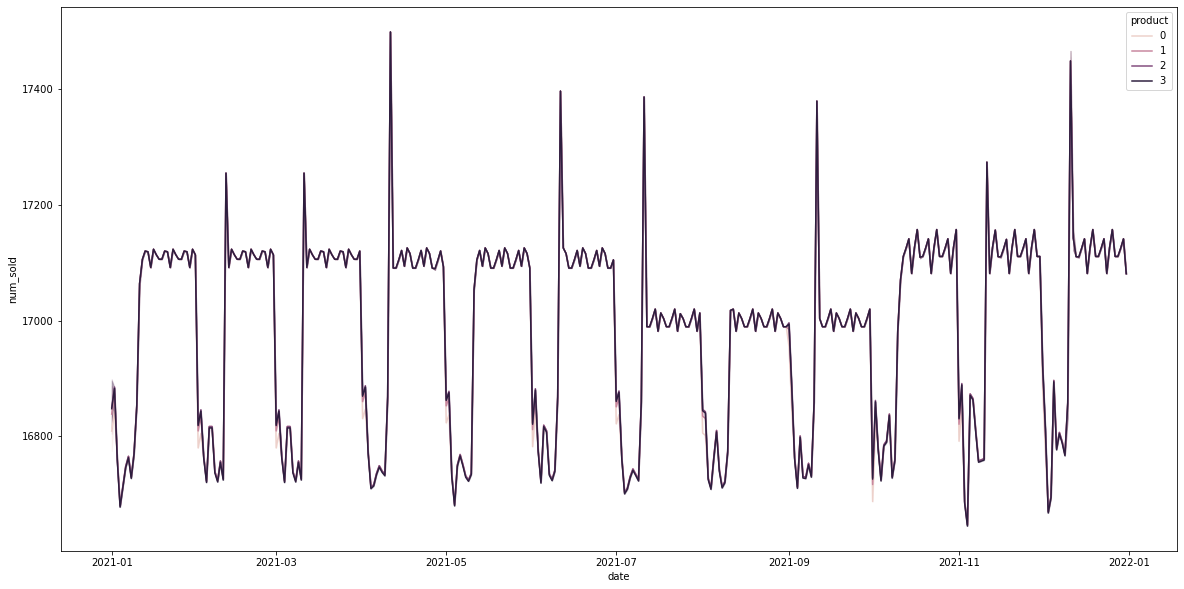

In [147]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(x= test['date'], y=test_data["num_sold"], hue = test_data['product']);

In [149]:
for i in range(0, len(test_data)):
    test_data['num_sold'][i] = test_data['num_sold'][i] * test_data['country_radio'][i] * test_data['store_weights'][i] * test_data['product_radio'][i]
    
test_data

C:\Users\cym80\AppData\Local\Temp\ipykernel_19700\4265569939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['num_sold'][i] = test_data['num_sold'][i] * test_data['country_radio'][i] * test_data['store_weights'][i] * test_data['product_radio'][i]


row_id  country  store  product  year  month  day  dayofweek  quarter  \
0       70128        0      0        0  2021      1    1          4        1   
1       70129        0      0        1  2021      1    1          4        1   
2       70130        0      0        2  2021      1    1          4        1   
3       70131        0      0        3  2021      1    1          4        1   
4       70132        0      1        0  2021      1    1          4        1   
...       ...      ...    ...      ...   ...    ...  ...        ...      ...   
17515   87643        5      0        3  2021     12   31          4        4   
17516   87644        5      1        0  2021     12   31          4        4   
17517   87645        5      1        1  2021     12   31          4        4   
17518   87646        5      1        2  2021     12   31          4        4   
17519   87647        5      1        3  2021     12   31          4        4   

       product_radio  country_radio  store_weights    num_sold  
0           0.279687       0.196195       0.742515  683.412903  
1           0.225051       0.196195       0.742515  550.874512  
2           0.191866       0.196195       0.742515  469.969879  
3           0.303396       0.196195       0.742515  743.054993  
4           0.279687       0.196195       0.257485  236.990112  
...              ...            ...            ...         ...  
17515       0.298452       0.164034       0.742515  620.931091  
17516       0.285682       0.164034       0.257485  206.109818  
17517       0.222461       0.164034       0.257485  160.497833  
17518       0.193405       0.164034       0.257485  139.535141  
17519       0.298452       0.164034       0.257485  215.323029  

[17520 rows x 13 columns]

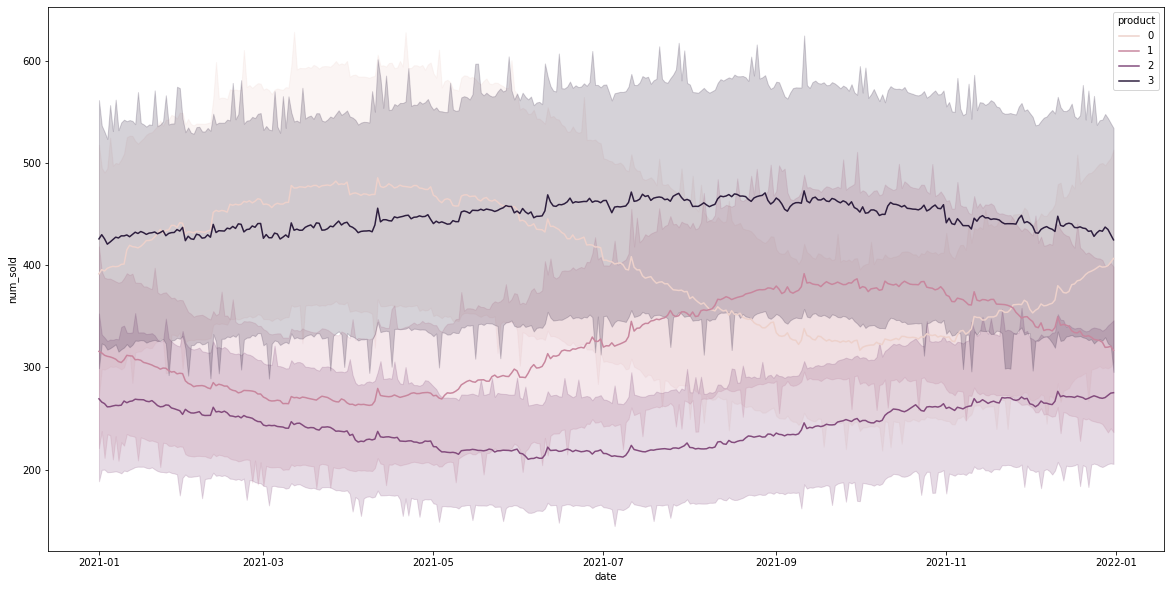

In [151]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = test_data, x= test['date'], y="num_sold", hue = 'product');

In [152]:
def plot_all_see(df):
    f, axes = plt.subplots(2, 2, figsize = (20, 15), sharex = True, sharey = True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data = plot_df, x = test['date'], y = 'num_sold', hue = 'country', style = 'store', ax = axes[n // 2, n% 2])
        axes[n // 2, n % 2].set_title("Product: "+str(prod))

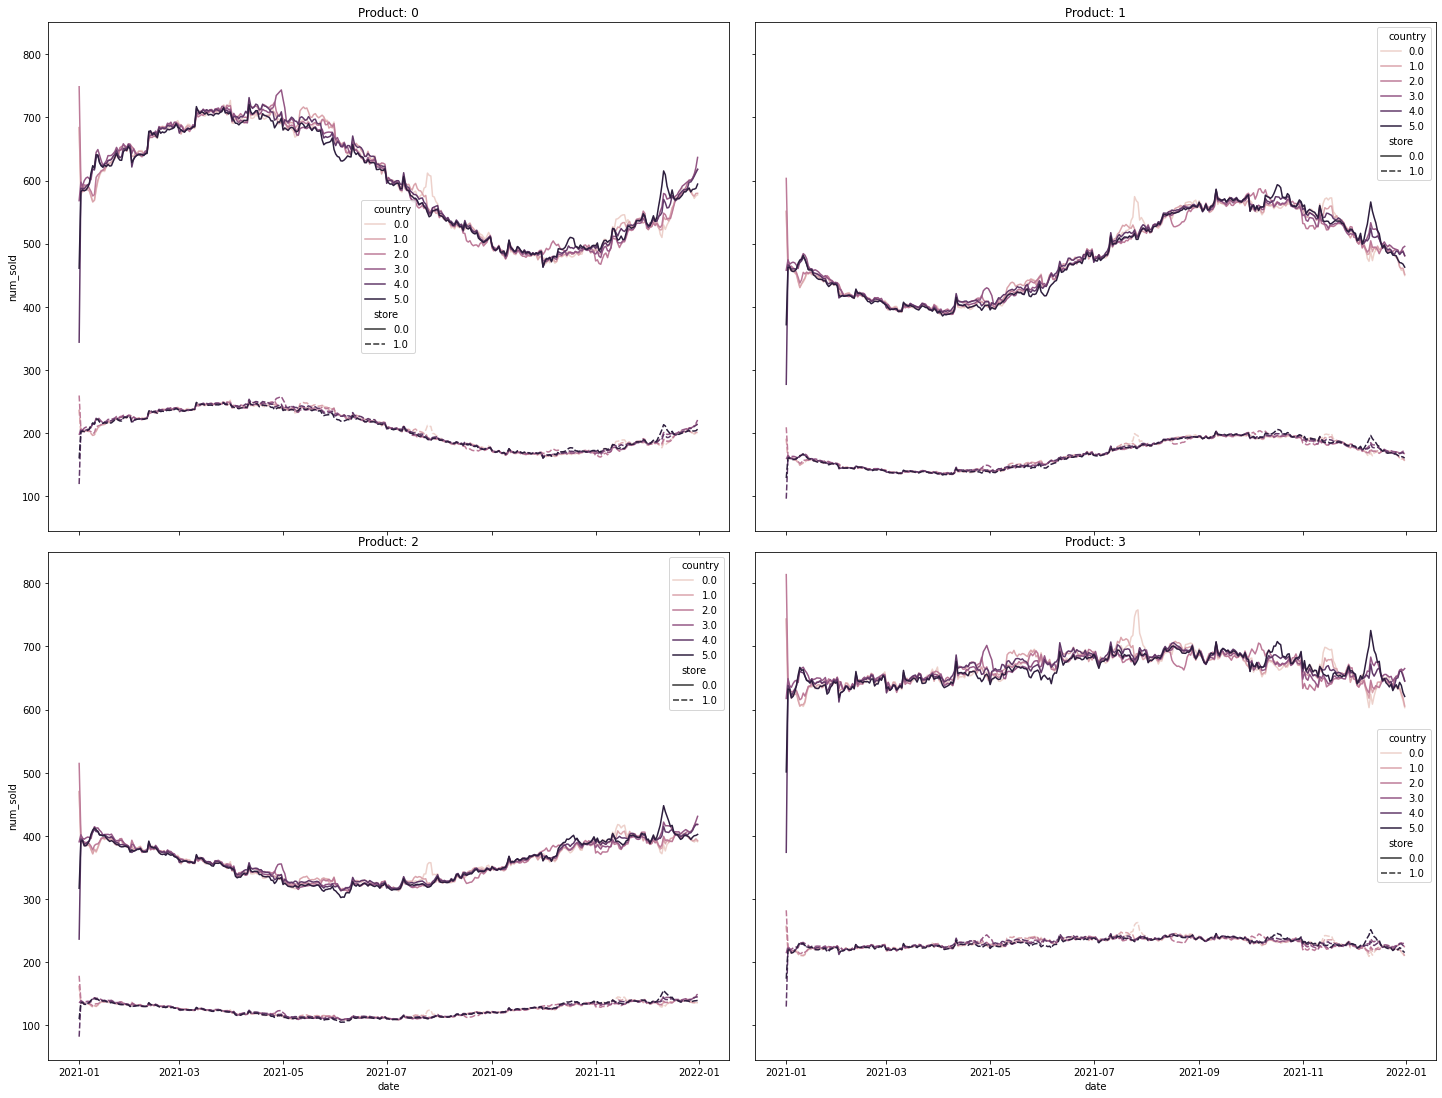

In [153]:
plot_all_see(test_data)

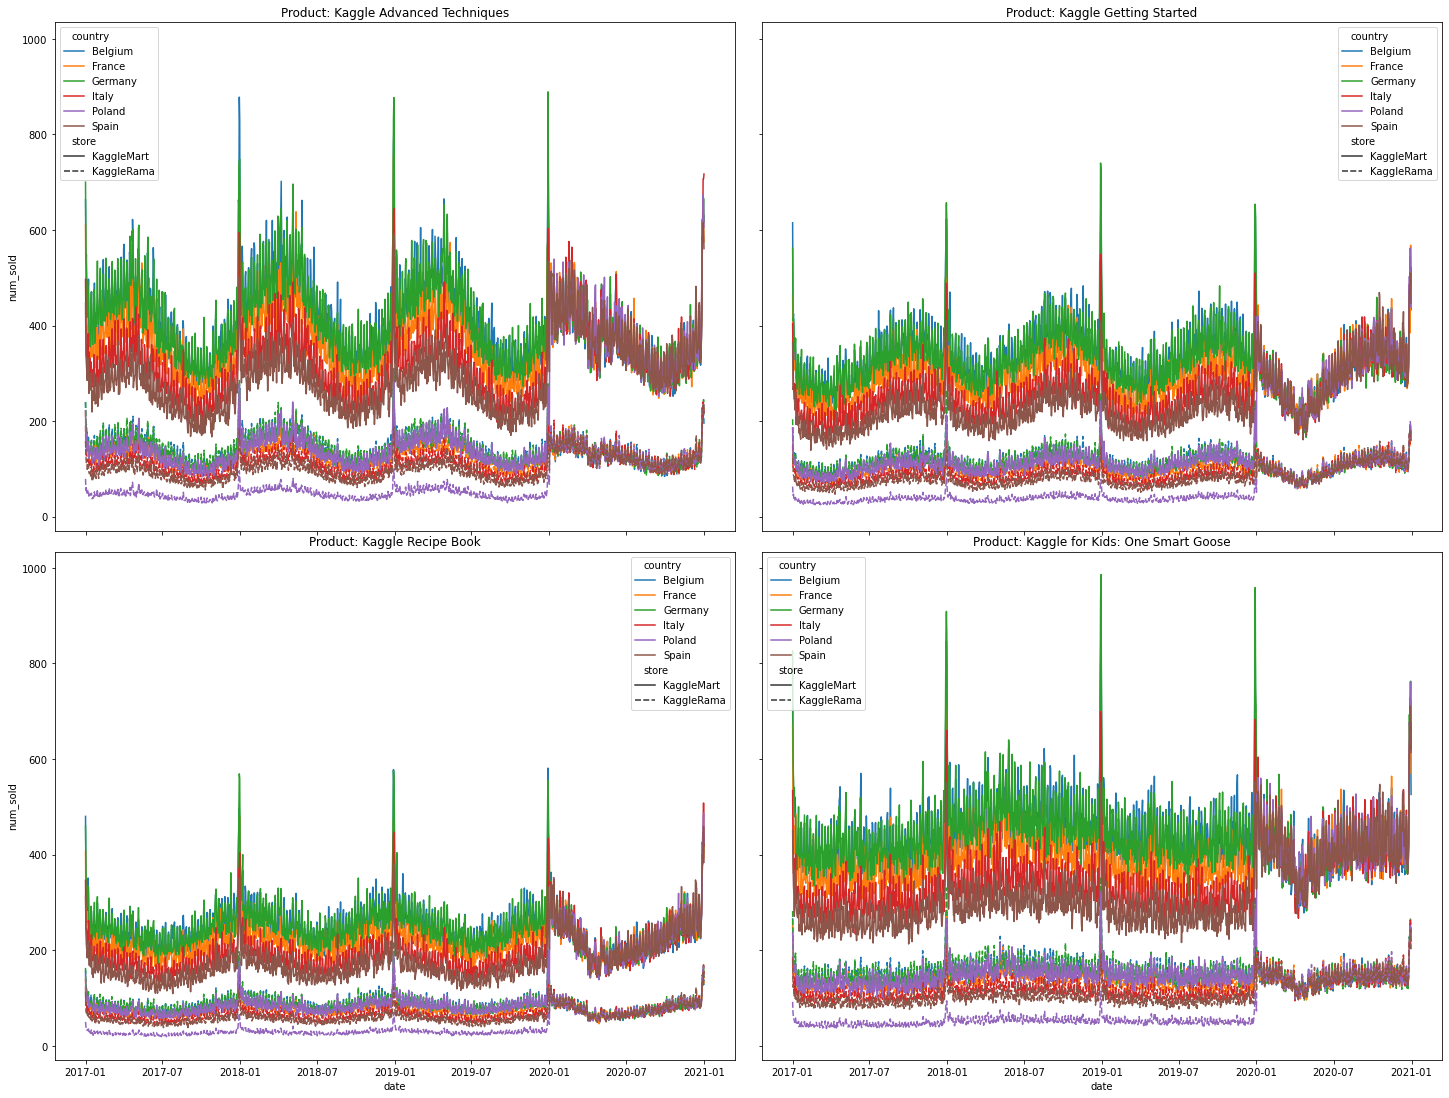

In [154]:
plot_all(train)

In [ ]:
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': test_data['num_sold_total']})
output.to_csv('Vot_XGB_rf_final.csv', index=False)
print("Your submission was successfully saved!")